In [65]:
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
path = Path('results/')

# for easy games
r_min = {
    "bigfish": 1,
    "bossfight": 0.5,
    "caveflyer": 3.5,
    "chaser": 0.5,
    "climber": 2,
    "coinrun": 5,
    "dodgeball": 1.5,
    "fruitbot": -1.5,
    "heist": 3.5,
    "jumper": 3,
    "leaper": 3,
    "maze": 5,
    "miner": 1.5,
    "ninja": 3.5,
    "plunder": 4.5,
    "starpilot": 2.5
}
 # for easy games
r_max = {
    "bigfish": 40,
    "bossfight": 13,
    "caveflyer": 12,
    "chaser": 13,
    "climber": 12.6,
    "coinrun": 10,
    "dodgeball": 19,
    "fruitbot": 32.4,
    "heist": 10,
    "jumper": 10,
    "leaper": 10,
    "maze": 10,
    "miner": 13,
    "ninja": 10,
    "plunder": 30,
    "starpilot": 64
}


In [127]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def load_results(root_path: Path, scalar_names: list, load_from_disk=False):
    # If load_from_disk is True, load the DataFrame from a CSV file in the root path
    if load_from_disk:
        df = pd.read_csv(root_path / 'data.csv')
    else:
        # Create an empty list to store the data
        data = []

        # Loop over all subdirectories of the root path (which should be 'gen' or 'eff')
        for track_path in root_path.iterdir():
            # Check if the subdirectory is a directory
            if track_path.is_dir():
                # Loop over all subdirectories of the track path (which should be algorithm names)
                for method_path in track_path.iterdir():
                    # Check if the subdirectory is a directory
                    if method_path.is_dir():
                        # Print the method name
                        print(method_path.name)
                        # Loop over all subdirectories of the algorithm path (which should be experiment names)
                        for exp_path in method_path.iterdir():
                            # Check if the subdirectory is a directory
                            if exp_path.is_dir():
                                # Initialize the event accumulator and load the event file
                                event_acc = EventAccumulator(str(exp_path))
                                event_acc.Reload()

                                # Initialize an empty DataFrame
                                df = pd.DataFrame()

                                # Loop over the scalar names
                                for scalar_name in scalar_names:
                                    # Check if the scalar exists in the event file
                                    if scalar_name in event_acc.Tags()['scalars']:
                                        # Get the scalar data
                                        scalar_data = event_acc.Scalars(scalar_name)

                                        # Create a DataFrame for the scalar data
                                        scalar_df = pd.DataFrame([(x.step, x.value) for x in scalar_data], columns=['step', scalar_name])

                                        # Merge the scalar DataFrame with the main DataFrame on the 'step' column
                                        if df.empty:
                                            df = scalar_df
                                        else:
                                            df = pd.merge(df, scalar_df, on='step', how='outer')

                                # If the main DataFrame is not empty, add columns for the track, algorithm, and experiment names
                                if not df.empty:
                                    df['track'] = track_path.name
                                    df['method'] = method_path.name
                                    df['experiment'] = exp_path.name

                                    # Add the DataFrame to the list of data
                                    data.append(df)

        # Concatenate all DataFrames into a single DataFrame
        df = pd.concat(data)

        # Save the DataFrame to a CSV file in the root path
        df.to_csv(root_path / 'data.csv', index=False)


    # Further process data

    df['task'] = df['experiment'].apply(lambda x: x.split('_')[0])
    df['seed'] = df['experiment'].apply(lambda x: x.split('seed=')[1].split('_')[0])

    # rename: charts/episodic_return_mean -> train, and charts/episodic_return_mean_eval -> eval
    df = df.rename(columns={'charts/episodic_return_mean': 'train', 'charts/episodic_return_mean_eval': 'eval'})

    # for every track, task and seed, create a smoothed train column - centered rolling mean (window 8)
    df['train_smoothed'] = df.groupby(['track', 'task', 'seed'])['train'].transform(lambda x: x.rolling(8, center=True).mean())

    # create new col which is the difference between the smoothed train and eval
    df['train_eval_ratio'] = df['train_smoothed'] / (df['eval'] + 1e-8)
    # clamp train_eval_ratio to -10,10
    df['train_eval_ratio'] = df['train_eval_ratio'].apply(lambda x: max(-10, min(10, x)))

    # normalize returns per task for train and eval -> train_norm, eval_norm (return - r_min[task])/(r_max[task] - r_min[task])
    df['train_norm'] = (df['train'] - df['task'].apply(lambda x: r_min[x])) / (df['task'].apply(lambda x: r_max[x]) - df['task'].apply(lambda x: r_min[x]))
    df['eval_norm'] = (df['eval'] - df['task'].apply(lambda x: r_min[x])) / (df['task'].apply(lambda x: r_max[x]) - df['task'].apply(lambda x: r_min[x]))
    df['train_norm_smoothed'] = (df['train_smoothed'] - df['task'].apply(lambda x: r_min[x])) / (df['task'].apply(lambda x: r_max[x]) - df['task'].apply(lambda x: r_min[x]))
    
    df['train_eval_ratio_norm'] = df['train_norm_smoothed'] / (df['eval_norm'] + 1e-8)
    df['train_eval_ratio_norm'] = df['train_eval_ratio_norm'].apply(lambda x: max(1, min(10, x)))
    return df


In [128]:
# Load all data
load_from_disk = True

scalars = ['charts/episodic_return_mean', 'charts/episodic_return_mean_eval']
df = load_results(path, scalars, load_from_disk=load_from_disk)

df_gen = df[df['track'] == 'gen']
df_eff = df[df['track'] == 'eff']


In [105]:
df_gen

,step,train,eval,track,method,experiment,task,seed,train_smoothed,train_eval_ratio,train_norm,eval_norm,train_norm_smoothed
0,16384,10.000000,NaN,gen,impala,heist_ppo_procgen_agent=impala_seed=2_time=167...,heist,2,NaN,NaN,1.000000,NaN,NaN
1,32768,10.000000,NaN,gen,impala,heist_ppo_procgen_agent=impala_seed=2_time=167...,heist,2,NaN,NaN,1.000000,NaN,NaN
2,49152,10.000000,NaN,gen,impala,heist_ppo_procgen_agent=impala_seed=2_time=167...,heist,2,NaN,NaN,1.000000,NaN,NaN
3,65536,1.372549,NaN,gen,impala,heist_ppo_procgen_agent=impala_seed=2_time=167...,heist,2,NaN,NaN,-0.327300,NaN,NaN
4,81920,8.571428,NaN,gen,impala,heist_ppo_procgen_agent=impala_seed=2_time=167...,heist,2,6.813753,NaN,0.780220,NaN,0.509808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125045,24920064,20.939394,NaN,gen,mixer-4x4,bigfish_ppo_procgen_agent=mixer4_1024_seed=0_t...,bigfish,0,20.667334,NaN,0.511267,NaN,0.504291
125046,24936448,21.000000,NaN,gen,mixer-4x4,bigfish_ppo_procgen_agent=mixer4_1024_seed=0_t...,bigfish,0,20.251645,NaN,0.512821,NaN,0.493632
125047,24952832,21.350000,NaN,gen,mixer-4x4,bigfish_ppo_procgen_agent=mixer4_1024_seed=0_t...,bigfish,0,NaN,NaN,0.521795,NaN,NaN
125048,24969216,17.393940,NaN,gen,mixer-4x4,bigfish_ppo_procgen_agent=mixer4_1024_seed=0_t...,bigfish,0,NaN,NaN,0.420357,NaN,NaN


In [88]:
def plot_tasks(data,x,y,hue,title):
    # for every task in the data
    sns.set_style('white')

    # on a 4x4 grid, plot the train plots for all tasks
    fig, axes = plt.subplots(4, 4, figsize=(15, 12), sharex=True)
    axes = axes.flatten()

    for i, task in enumerate(sorted(data['task'].unique())):
        # get the data for the task
        task_data = data[data['task'] == task].dropna()

        # plot the train data
        sns.lineplot(x=x, y=y, hue=hue, data=task_data, ax=axes[i], legend=True)
        axes[i].set_title(task)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].legend(loc='lower right')

        # remove the legend from all but the last plot
        if i < 15:
            axes[i].get_legend().remove()
        

    # set the title
    fig.suptitle(title, fontsize=21)

    plt.tight_layout()

In [ ]:
def plot_normalized(data,x,y,hue,title):
    # average y across every task and plot on single plot
    sns.set_style('white')

    sns.lineplot(x=x, y=y, hue=hue, data=data, legend=True)

# Generalisation Plots

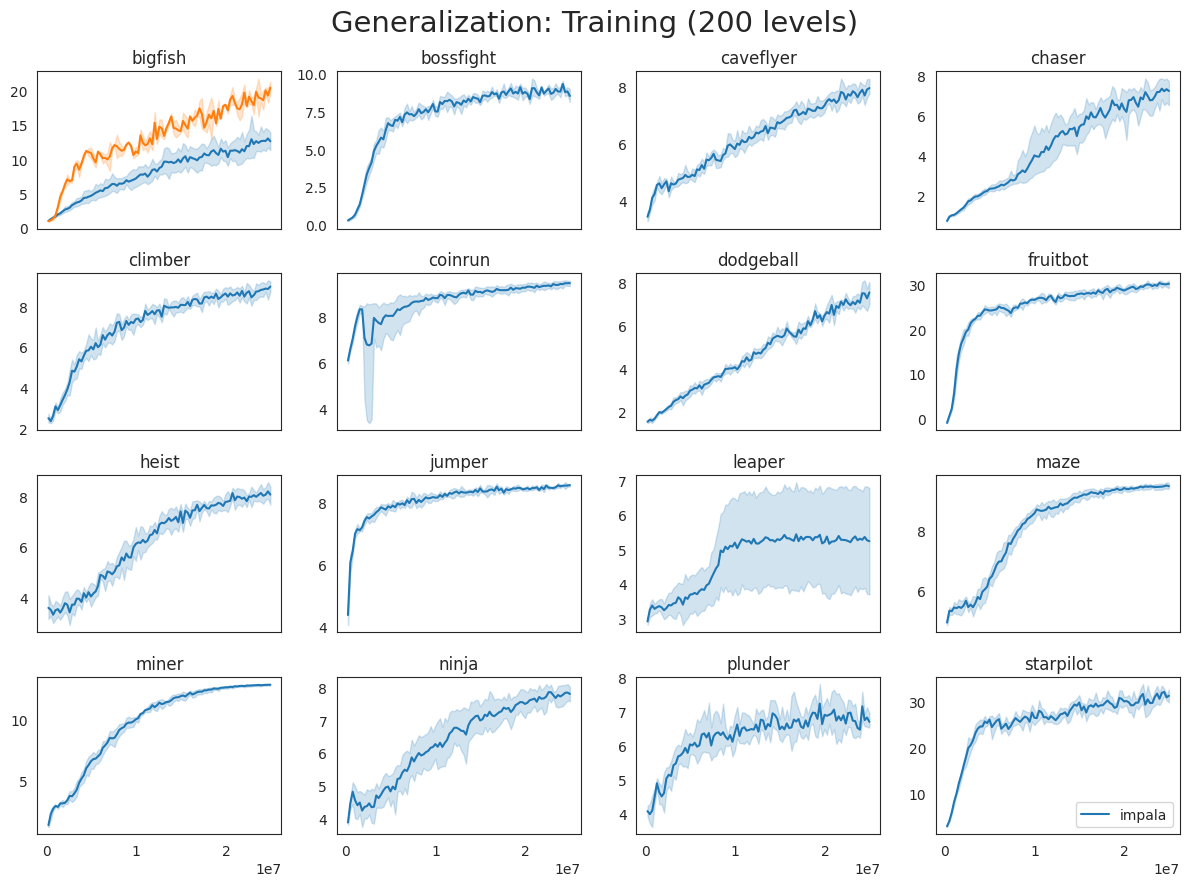

In [62]:
plot_tasks(data=df_gen, x='step', y='train_smoothed', hue='method', title='Generalization: Training (200 levels)')

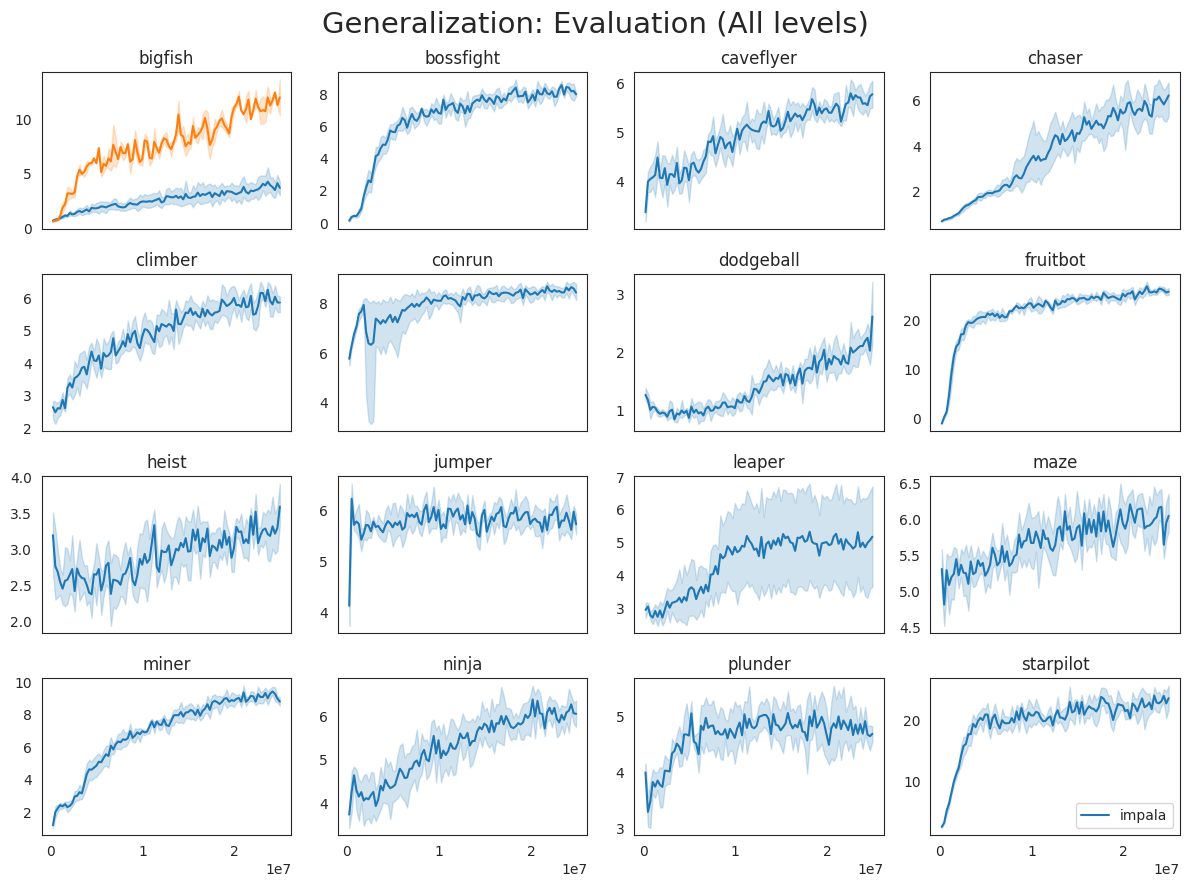

In [63]:
plot_tasks(data=df_gen, x='step', y='eval', hue='method', title='Generalization: Evaluation (All levels)')

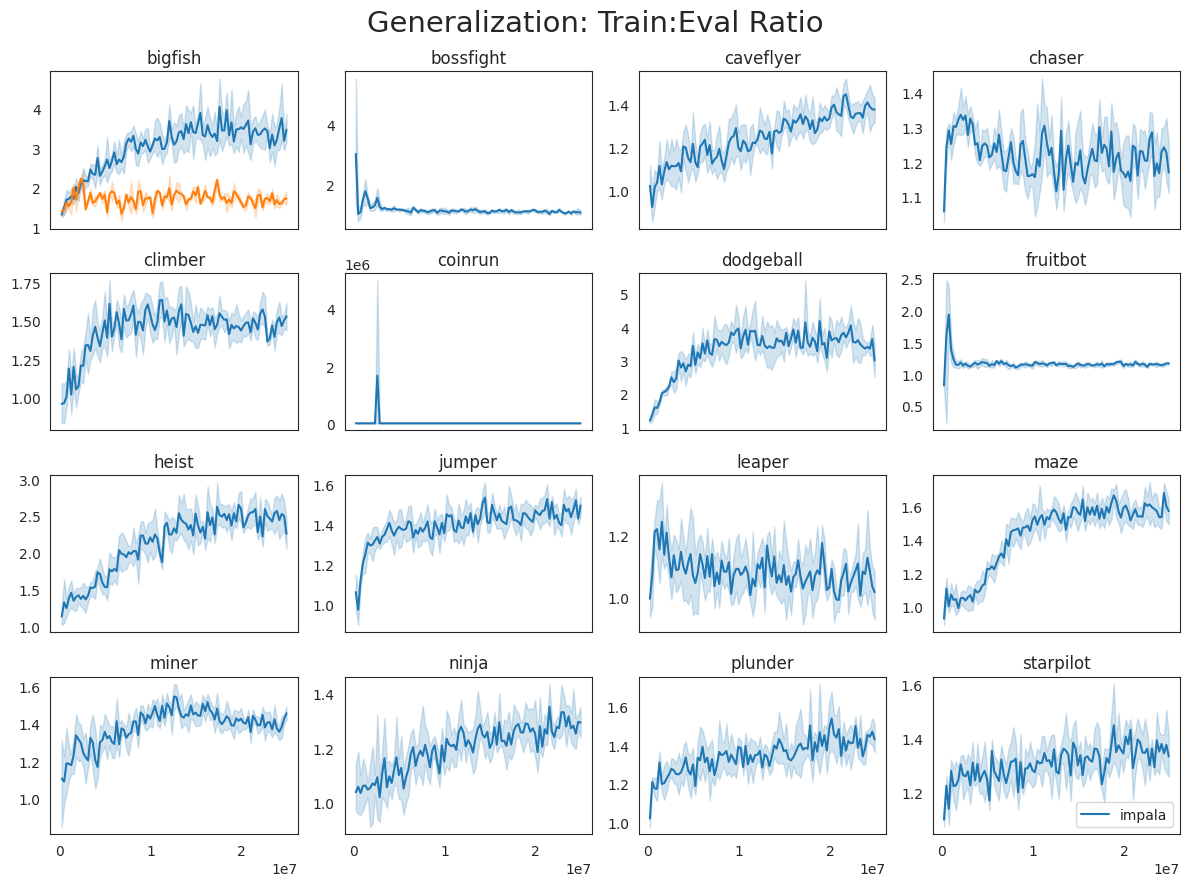

In [64]:
plot_tasks(data=df_gen, x='step', y='train_eval_ratio', hue='method', title='Generalization: Train-Eval Ratio')

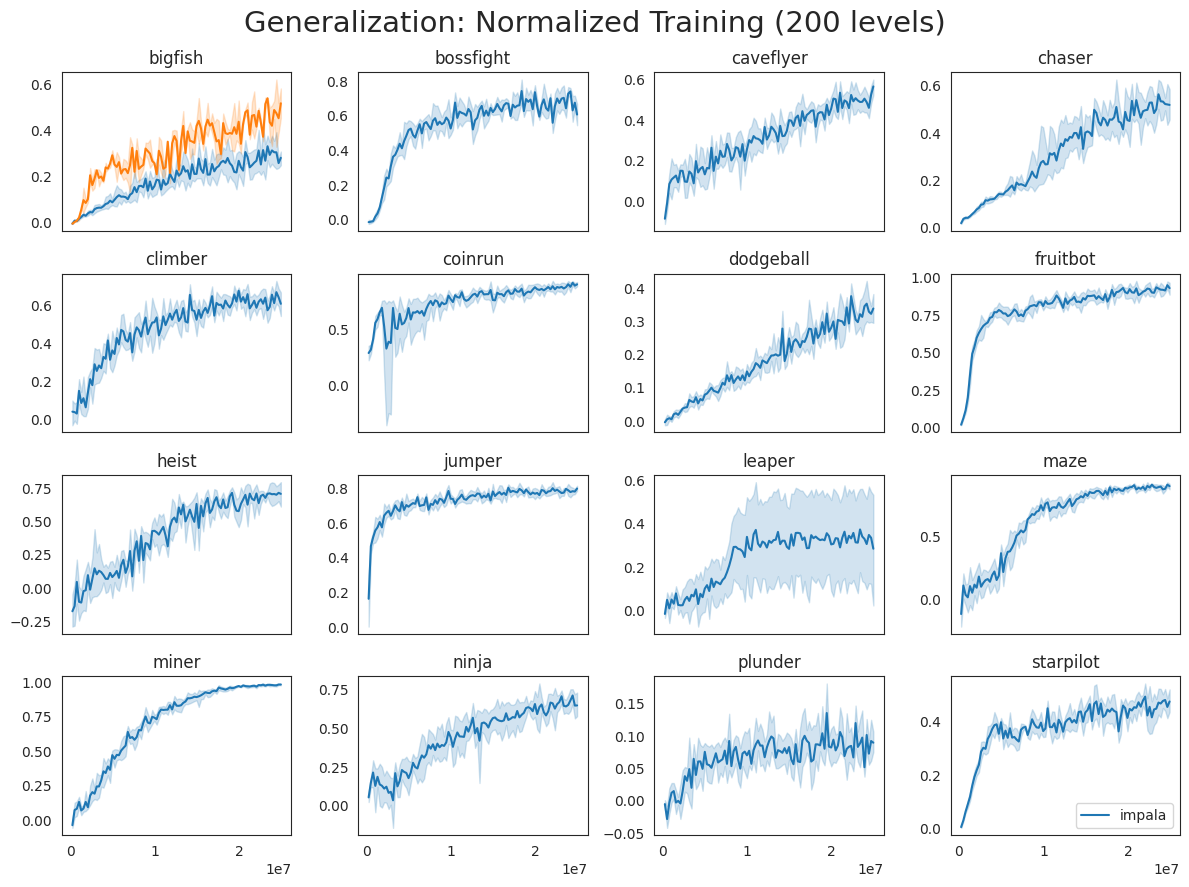

In [69]:
plot_tasks(data=df_gen, x='step', y='train_norm', hue='method', title='Generalization: Normalized Training (200 levels)')

<AxesSubplot:xlabel='step', ylabel='train_norm'>

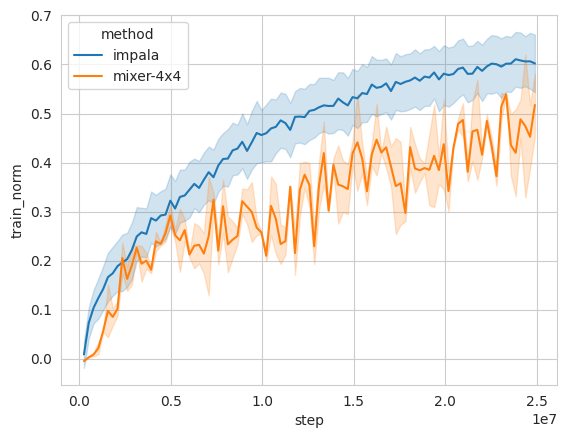

In [89]:
#set grid
sns.set_style('whitegrid')

sns.lineplot(x='step', y='train_norm', hue='method', data=df_gen.dropna(), legend=True)

<AxesSubplot:xlabel='step', ylabel='eval_norm'>

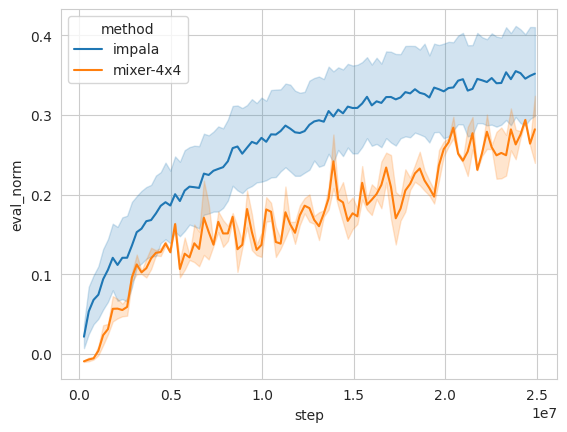

In [90]:
sns.lineplot(x='step', y='eval_norm', hue='method', data=df_gen, legend=True)

<AxesSubplot:xlabel='step', ylabel='train_eval_ratio_norm'>

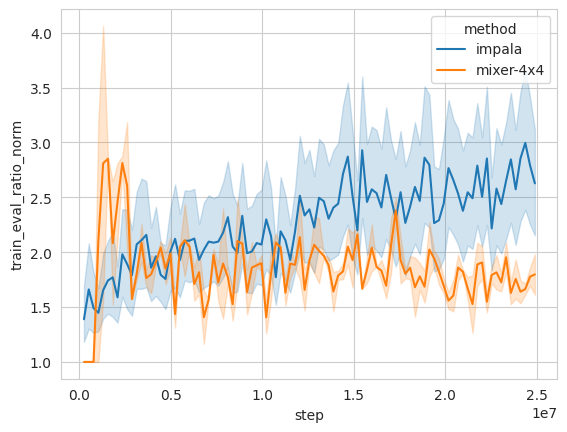

In [129]:
sns.lineplot(x='step', y='train_eval_ratio_norm', hue='method', data=df_gen.dropna(), legend=True)

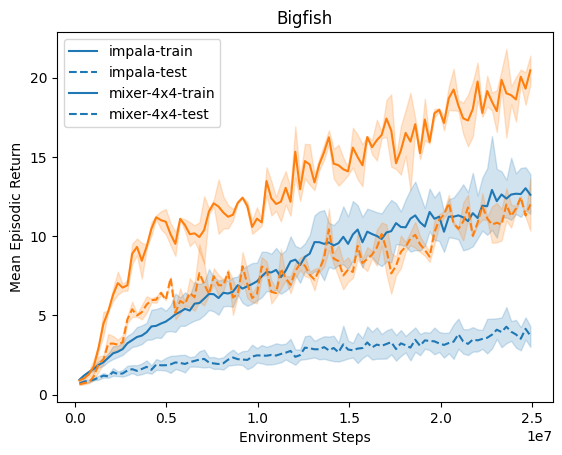

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Filter the data for the 'bigfish' task
filtered_data = df[df['task'] == 'bigfish'].dropna()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the solid line for the 'train_smooth' data
sns.lineplot(ax=ax, data=filtered_data, x='step', y='train_smoothed', hue='method')

# Plot the dotted line for the 'eval' data
sns.lineplot(ax=ax, data=filtered_data, x='step', y='eval', hue='method', linestyle='--')

# Get the unique methods from the data
methods = filtered_data['method'].unique()

# Create custom legend handles and labels
legend_handles = []
legend_labels = []

for method in methods:
    legend_handles.append(mlines.Line2D([], [], linestyle='-', label=f'{method}-train'))
    legend_handles.append(mlines.Line2D([], [], linestyle='--', label=f'{method}-test'))
    legend_labels.append(f'{method}-train')
    legend_labels.append(f'{method}-test')

# Set the custom legend
ax.legend(handles=legend_handles, labels=legend_labels) # , title='<method>-<train/test>'

# set y label
ax.set_ylabel('Mean Episodic Return')

# set x label
ax.set_xlabel('Environment Steps')

# set title
ax.set_title('Bigfish')

# Show the plot
plt.show()
